<a target="_blank" href="https://colab.research.google.com/github/rohitm487/GenAI-Tutorial/blob/main/LLM_Inference_optimization_KV_Caching.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install transformers
!pip3 install torch torchaudio torchvision torchtext torchdata

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

The value matrix (V) is used to transform the input embeddings again. This transformation generates weighted value vectors, which capture the importance of each input token for predicting the next token in the sequence

# Process of text generation using autoregressive model.
- Auto Regressive model meaning - जो पिछले मूल्यों के आधार पर भविष्य के मूल्यों की भविष्यवाणी करते हैं.

- Iteratively generate token one at a time.
  - Prefill and Decode phase. Optimizing it with KV caching to speed up attention calculation.

In [29]:
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

#Loading a very small llm from hugging face
- Reason for using smaller model for latency sensitive task such as auto suggest. Smaller model generally have lower latency.

In [30]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [31]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


# Decoder Only (Auto regressive model)
- Generates one token at a time.
- Foundation for modern LLM

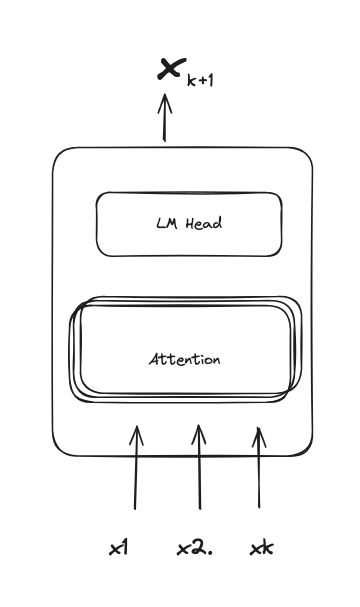

In [46]:
prompt = "How are you doing"
inputs = tokenizer(prompt,return_tensors = "pt")
inputs

{'input_ids': tensor([[2437,  389,  345, 1804]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

EXP - We get token for each word in our prompt. Attention mask we will see later while we will see the concept called batching.

In [54]:
# We don't need gradient durning inference, with no grad we specify we don't need memory for extra memory for gredients.
with torch.no_grad():
  outputs = model(input_ids = inputs['input_ids'],attention_mask = inputs["attention_mask"])

logits = outputs.logits
print(logits.shape) # torch.Size([1, 8, 50257]) Batch Size, Sequence Length, vocabulary Size.

torch.Size([1, 4, 50257])


logits shape tells us (Batch Size, Sequence Length, vocabulary Size.). Vocabulary size is 50257 tokens, We want to predict out of these 50257 token which one we want use as the next token.

In [55]:
batch_index = 0 # we have only one batch ["1", 5, 50257]


#Last index corresponding to the next token
#Model actually generates logits for every token in the input

#Input - "How are you doing"
#InputIdx- 0   1   2    3
idx = 1


logits = logits[batch_index,idx,:] # : specify from all tokens from vocab
logits.argmax()

tensor(345)

In [56]:
tokenizer.decode(logits.argmax())

' you'

In [6]:
batch_index = 0

last_element_idx = -1

#we need last index to predict after it.
last_logits = logits[batch_index,last_element_idx,:] # : specify from all tokens from vocab
last_logits,last_logits.shape

(tensor([-107.6652, -105.0714, -109.5767,  ..., -112.3652, -111.6757,
         -106.6163]),
 torch.Size([50257]))

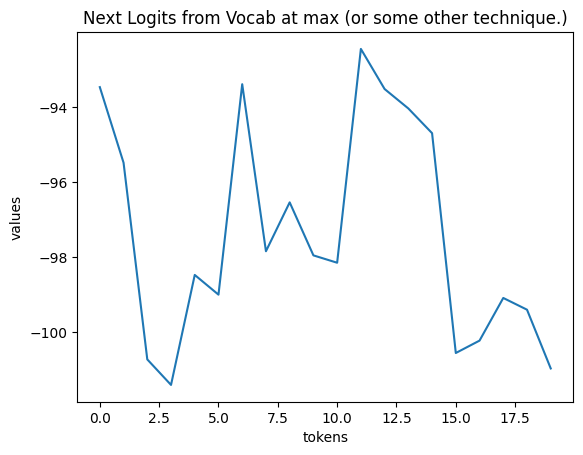

In [63]:

plt.plot(last_logits[:20])
plt.title('Next Logits from Vocab at max (or some other technique.)')
plt.xlabel("tokens")
plt.ylabel("values")

plt.show()

In [9]:
next_token_index = last_logits.argmax()
next_token_index

tensor(1256)

In [10]:
tokenizer.decode(next_token_index)

' lot'

# Other recommended tokens

In [11]:
top10_token = torch.topk(last_logits,k=10)
top10_token

torch.return_types.topk(
values=tensor([-95.7501, -97.0276, -97.0907, -97.3788, -97.5056, -97.5881, -97.6399,
        -97.6681, -97.7347, -97.7818]),
indices=tensor([1256,  845, 1049, 3236, 1738, 3580,  922, 1913, 1263,  649]))

In [12]:
top10_token_indices = top10_token.indices

In [13]:
tokenizer.decode(top10_token_indices).split(" ")

['',
 'lot',
 'very',
 'great',
 'huge',
 'reason',
 'difference',
 'good',
 'strong',
 'big',
 'new']

Our input -
- `prompt = "Hey there ! How are"`
- `encoded_promt_using_tokenizer is tensor([[10814,   612,  5145,  1374,   389]])`

Our output -
- `output_index = 345`
- `decoded_output =" you"`

Next what -

`next_input = [prev_input + prev_output] predict next token.`

- We will pass this to model input `{'input_ids': [prev_input + prev_output], 'attention_mask': [1, 1, 1, 1, 1] + [1] }`.

In [14]:
next_inputs = {
    'input_ids':
    torch.cat(
    [inputs["input_ids"], next_token_index.reshape((1,1))],
    dim=1
    ),

    'attention_mask':
      torch.cat(
          [inputs["attention_mask"], torch.tensor([[1]])],
          dim=1
          )
      }

In [15]:
next_inputs

{'input_ids': tensor([[1858,  318,  257, 1256]]),
 'attention_mask': tensor([[1, 1, 1, 1]])}

previous `{'input_ids': tensor([[10814,   612,  5145,  1374,   389]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}`

# Calculate time in generating next token

In [16]:
def next_token_fun(inputs):
  with torch.no_grad():
    outputs = model(**inputs)
  logits = outputs.logits
  last_logits = logits[0,-1,:]
  next_token = last_logits.argmax()
  return next_token

next_token_fun(inputs)

tensor(1256)

Text(0, 0.5, 'time')

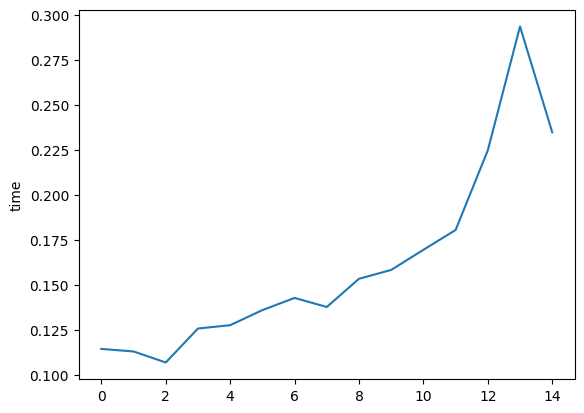

In [24]:
gen_tokens = []
next_inputs = inputs
#print(next_inputs)
durations = []
for _ in range(15):
  start = time.time()
  #print(next_inputs)
  next_token_idx = next_token_fun(next_inputs)
  end = time.time()
  durations.append(end - start)

  next_inputs = {
    'input_ids':
    torch.cat(
    [next_inputs["input_ids"], next_token_idx.reshape((1,1))],
    dim=1
    ),

    'attention_mask':
      torch.cat(
          [next_inputs["attention_mask"], torch.tensor([[1]])],
          dim=1
          )
      }

  next_token = tokenizer.decode(next_token_idx)
  gen_tokens.append(next_token)



plt.plot(durations)
plt.ylabel("time")

In [112]:
import numpy as np

input_sequence = np.array([
    [0.1, 0.2, 0.3],  # Token input embedding 1 - hey
    [0.4, 0.5, 0.6],  # Token input embedding 2 - there
    [0.7, 0.8, 0.9],  # Token input embedding 3 - how
    [0.2, 0.3, 0.4]   # Token input embedding 4 - are
])

# Initialize query matrix, key matrix, and value matrix
query_matrix = np.random.rand(3, 3)  # Random query matrix
key_matrix = np.random.rand(3, 3)    # Random key matrix
value_matrix = np.random.rand(3, 3)  # Random value matrix

# Initialize lists to store attention scores and weighted value vectors
query_vectors = []
key_vectors_all = []
value_vectors_all = []

# Initialize counters
query_calc_count = 0
key_calc_count = 0
value_calc_count = 0

# Compute attention scores and weighted value vectors for each token
for i in range(input_sequence.shape[0]):
    query_vector = np.dot(query_matrix, input_sequence[i])
    query_vectors.append(query_vector)

    print(f"\n\n-----Q {i}--------")
    print(query_vector)
    query_calc_count += 1

    key_vectors = []
    value_vectors = []

    for j in range(i + 1):  # Loop over tokens up to the current one
        keys_vector = np.dot(key_matrix, input_sequence[j])
        key_vectors.append(keys_vector)
        key_calc_count += 1
        print("K")
        print(keys_vector)

        vals_vector = np.dot(value_matrix, input_sequence[j])
        value_vectors.append(vals_vector)
        value_calc_count += 1
        print("V")
        print(vals_vector)

    key_vectors_all.append(key_vectors)
    value_vectors_all.append(value_vectors)

print(f"Number of times query vector calculation: {query_calc_count}")
print(f"Number of times key vector calculation: {key_calc_count}")
print(f"Number of times value vector calculation: {value_calc_count}")




-----Q 0--------
[0.19353556 0.39420782 0.14624113]
K
[0.32950449 0.27679431 0.11387277]
V
[0.13034299 0.31573927 0.21915847]


-----Q 1--------
[0.52439622 0.99595437 0.4024684 ]
K
[0.32950449 0.27679431 0.11387277]
V
[0.13034299 0.31573927 0.21915847]
K
[0.7899142  0.71898625 0.37918357]
V
[0.30175735 0.6754913  0.64727279]


-----Q 2--------
[0.85525688 1.59770091 0.65869567]
K
[0.32950449 0.27679431 0.11387277]
V
[0.13034299 0.31573927 0.21915847]
K
[0.7899142  0.71898625 0.37918357]
V
[0.30175735 0.6754913  0.64727279]
K
[1.25032391 1.16117819 0.64449438]
V
[0.4731717  1.03524332 1.07538712]


-----Q 3--------
[0.30382245 0.59479    0.23165022]
K
[0.32950449 0.27679431 0.11387277]
V
[0.13034299 0.31573927 0.21915847]
K
[0.7899142  0.71898625 0.37918357]
V
[0.30175735 0.6754913  0.64727279]
K
[1.25032391 1.16117819 0.64449438]
V
[0.4731717  1.03524332 1.07538712]
K
[0.48297439 0.42419162 0.2023097 ]
V
[0.18748111 0.43565661 0.36186324]
Number of times query vector calculation: 4


In [25]:
gen_tokens

[' lot',
 ' of',
 ' work',
 ' to',
 ' be',
 ' done',
 ' to',
 ' make',
 ' sure',
 ' that',
 ' the',
 ' system',
 ' is',
 ' working',
 ' properly']

This is where the cost of lot of llm comes from.

In transformer most of computation cost is associated with attention calculation.
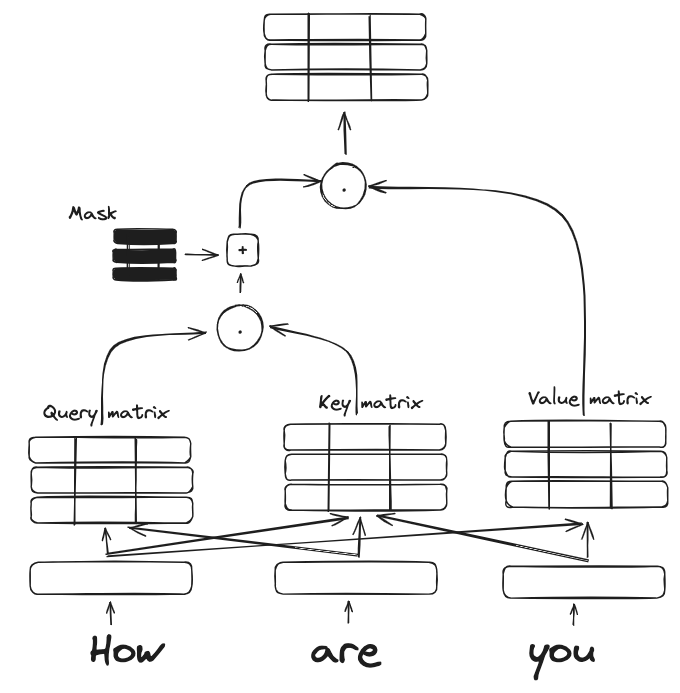

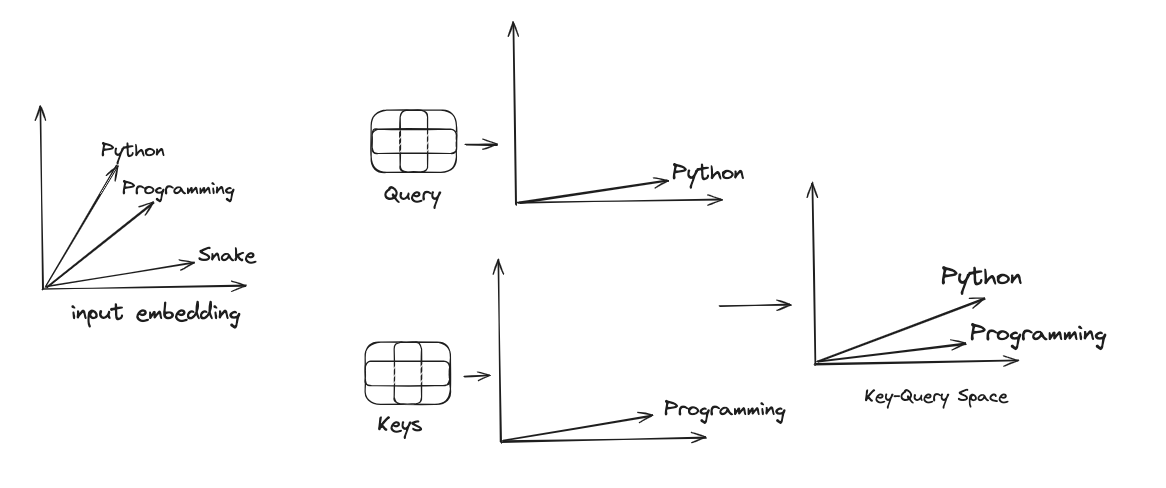

# In LLMS choice of selecting of these some of less likely tokens depends on temperature.

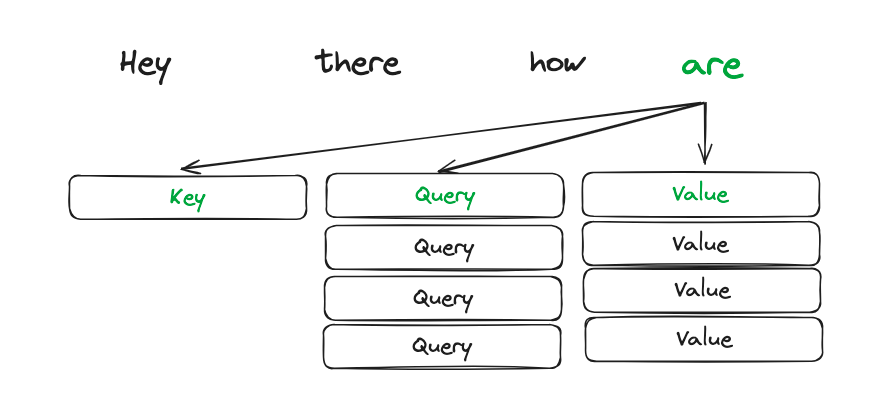

In [26]:
def next_token_past_kv(inputs):
  with torch.no_grad():
    outputs = model(**inputs)
  logits = outputs.logits
  last_logits = logits[0,-1,:]
  next_token = last_logits.argmax()
  return next_token,outputs.past_key_values


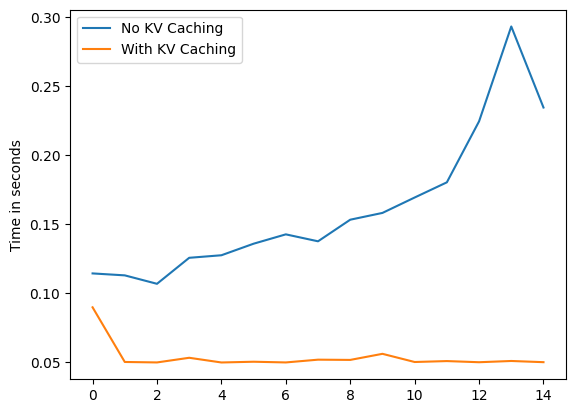

In [27]:
gen_tokens = []
next_inputs = inputs
durations_cache = []
for _ in range(15):
  start = time.time()

  next_token_idx , past_key_values = next_token_past_kv(next_inputs)

  end = time.time()
  durations_cache.append(end - start)

  next_inputs = {
    'input_ids': next_token_idx.reshape((1,1)),

    'attention_mask':
      torch.cat(
          [next_inputs["attention_mask"], torch.tensor([[1]])],
          dim=1
          ),

      'past_key_values':past_key_values

      }

  next_token = tokenizer.decode(next_token_idx)
  gen_tokens.append(next_token)


plt.plot(durations,label="No KV Caching")
plt.plot(durations_cache,label="With KV Caching")
plt.ylabel("Time in seconds")
plt.legend()
plt.show()

In [23]:
gen_tokens

[' lot',
 ' of',
 ' work',
 ' to',
 ' be',
 ' done',
 ' to',
 ' make',
 ' sure',
 ' that',
 ' the',
 ' system',
 ' is',
 ' working',
 ' properly']

Credit - **Efficient NLP**


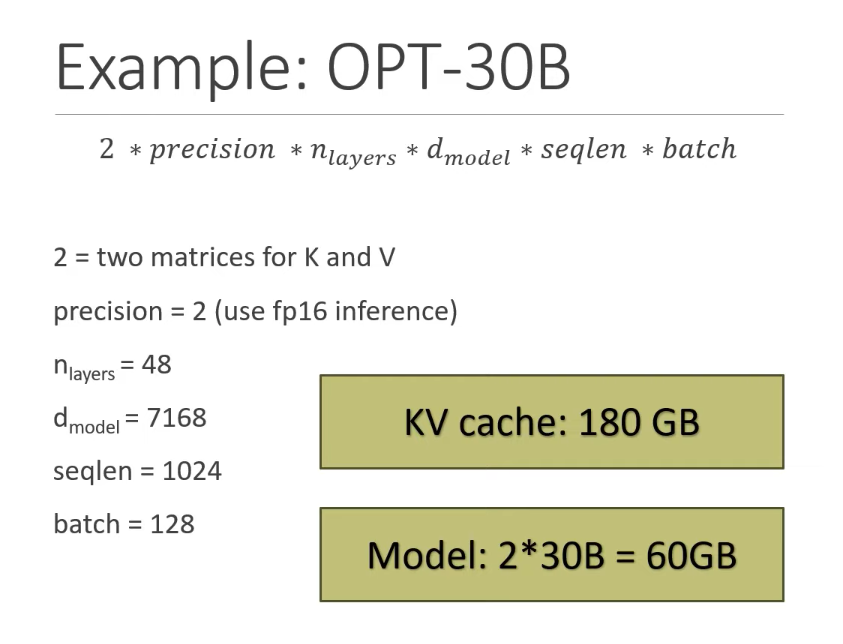

# Redundant Calculations